In [1]:
import pickle
from pathlib import Path
import jax.numpy as jnp
from jax.tree_util import tree_map
from scipy.stats import entropy

import arviz as az

In [2]:
from mubelnet.utils import perplexity
import jax.numpy as jnp

from dataset import load_mutation_spectrum, COSMIC_WEIGHTS


X_train, X_test = load_mutation_spectrum()


MODEL = 'multinomial_dirichlet_believe'
_bottom_layer_name = (
    f"{MODEL}/~/multinomial_layer"
    if MODEL == "multinomial_dirichlet_believe"
    else f"{MODEL}/~/poisson_layer"
)

In [3]:
state_dir = Path('/home/hylke/multdirbelnet/multinomial_dirichlet_believe/78/samples')
pickles = sorted(state_dir.glob('sample_*.pkl'))
# Load the states from the pickles and concatenate along the second axis.
state_checkpoints = []
for p_file in pickles[-6:]:
    with open(p_file, 'rb') as fi:
        states = pickle.load(fi)
        states_thinned = tree_map(lambda x: x[:, ::5], states)
        del states
        state_checkpoints.append(states_thinned)

states = tree_map(lambda *xs: jnp.concatenate(xs, axis=1), *state_checkpoints)

TypeError: tree_map() missing 1 required positional argument: 'tree'

In [6]:
def probability(state):
    bottom_state = state[_bottom_layer_name]
    phi = COSMIC_WEIGHTS.to_numpy()
    theta = bottom_state["theta"]
    probs = theta @ phi
    probs /= probs.sum(axis=-1, keepdims=True)
    return probs

def evaluate(params, states, X, axis=[0, 1]):
    """Compute perplexity over chains and samples by default (axis=[0, 1])."""
    probs = probability(params, states).mean(axis)
    return perplexity(X, probs)

Evaluate performance

In [7]:
from statkit.non_parametric import bootstrap_score

probs = probability(states).mean(axis=[0, 1])
pp_estimate_1 = bootstrap_score(X_test, probs, metric=perplexity, random_state=42)
print("Perplexity on unseen observations", pp_estimate_1)
print(pp_estimate_1.latex())

Perplexity on unseen observations 6.20e+01 (95 % CI: 6.14e+01-6.27e+01)
6.20$^{+0.07}_{-0.07} \cdot 10^{1}$


In [8]:
# Convert states to arviz inference data.
r_entropy = entropy(states["multinomial_dirichlet_believe/~/cap_layer"]["r"], axis=-1)
theta_entropy = entropy(states["multinomial_dirichlet_believe/~/cap_layer"]["theta"], axis=-1)
idata = az.convert_to_inference_data(
    {
        "c": states["multinomial_dirichlet_believe/~/cap_layer"]["c"],
        "s[r]": r_entropy,
        "s[theta]": theta_entropy,
    }
)

In [9]:
del states
isummary = az.summary(idata)

/home/hylke/.local/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'s[r]'}>,
        <AxesSubplot:title={'center':'s[r]'}>]], dtype=object)

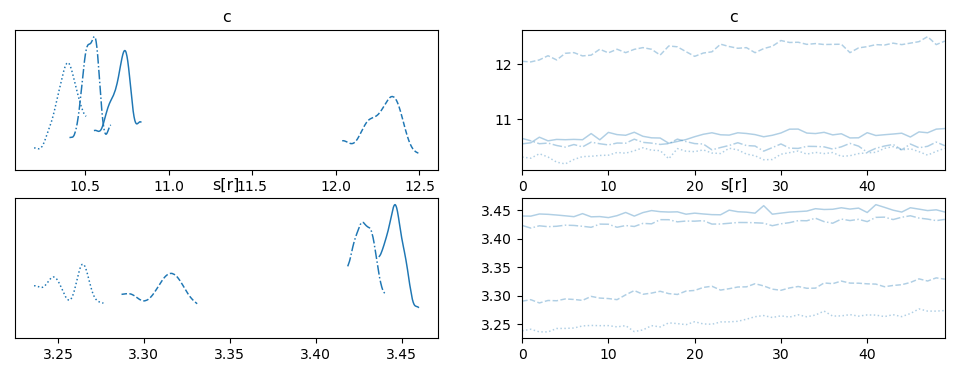

In [12]:
az.plot_trace(idata, var_names=["c", "s[r]"])

In [13]:
theta_cols = [c_name for c_name in isummary.index if 'theta' in c_name]

In [14]:
isummary.loc[theta_cols]['r_hat'].describe()

count    4645.000000
mean        1.638784
std         0.491234
min         0.990000
25%         1.250000
50%         1.540000
75%         1.890000
max         4.280000
Name: r_hat, dtype: float64